# Housing dataset experiment

In this notebook we will try to study the relationship between a given subset $X$ of a dataset $Z$ and the whole dataset. The steps will be the following:
1. Load the dataset and normalize its values.
2. Choose a random subset of the dataset of a given size.
3. Train a MLP on the random subset as a train set and use the rest as test.
4. Study the partial matching between the persistence diagrams for the qualitative study

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.spatial.distance as dist
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gudhi
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.spatial.distance as dist
import itertools
from scipy.sparse.csgraph import minimum_spanning_tree

import tdqual.topological_data_quality_0 as tdqual

import warnings
warnings.filterwarnings("ignore")
plots_dir = "housing_images/"

housing = datasets.fetch_california_housing()

Z=housing["data"]
Z = preprocessing.normalize(Z)
y=housing["target"]
n_classes = 4 # +1
labels=np.digitize(y,np.linspace(0,5.1,n_classes))-1


def subsetZ(Z,labels,size):#,noise_id, size_noise):
    ids = np.random.choice(len(Z), replace=False, size=size)
    X=Z[ids]
    y=labels[ids]
    #s=np.shape(S[y==noise_id])
    #noise = np.random.normal(0,size_noise, s)
    #S[y==noise_id]=S[y==noise_id]+noise
    return X, y, ids

## Choosing $X\subseteq Z$

In [12]:
size=1000
print("Size of each class on input data:")
for i in set(labels):
    print("Class ",i,": ",np.sum(labels==i)," proportion: ", np.sum(labels==i)/len(labels))
X, y, X_indices = subsetZ(Z,labels,size)
print("Size of each class on train data:")
for i in set(labels):
    print("Class ",i,": ",np.sum(y==i)," proportion: ", np.sum(y==i)/len(y))

Size of each class on input data:
Class  0 :  9531  proportion:  0.4617732558139535
Class  1 :  8215  proportion:  0.39801356589147285
Class  2 :  2894  proportion:  0.14021317829457364
Size of each class on train data:
Class  0 :  427  proportion:  0.427
Class  1 :  417  proportion:  0.417
Class  2 :  156  proportion:  0.156


## MLP training and performance measure

In [6]:
Z_test = np.array([Z[i] for i in range(len(Z)) if i not in X_indices])
y_test = np.array([labels[i] for i in range(len(labels)) if i not in X_indices])
input_dim = np.shape(X)[1]
verbose = False
epochs = 1000
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256, activation="relu",use_bias=True, input_shape=(input_dim,)))
model.add(tf.keras.layers.Dense(128, activation="relu",use_bias=True))
model.add(tf.keras.layers.Dense(64, activation="relu",use_bias=True))
model.add(tf.keras.layers.Dense(n_classes-1, activation="softmax",use_bias=True))


callback = keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=10)


opt  = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=["accuracy"])
print("Training neural network...")
acc_test = []
acc_train = []
for i in range(10):
    history = model.fit(X,y,epochs=epochs, verbose = verbose,callbacks=[callback])
    acc_test.append(model.evaluate(Z_test,y_test)[1])
    acc_train.append(model.evaluate(X,y)[1])
i=np.argmax(acc_test)
print("Acc on test: ",acc_test[i])
print("Acc on train: ",acc_train[i])

2024-06-22 07:59:01.570750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/MonitorSoftware/lib:/usr/sfw/lib:/usr/local/lib:/opt/MonitorSoftware/lib:/usr/sfw/lib:/usr/local/lib:/opt/MonitorSoftware/lib:/usr/sfw/lib:/usr/local/lib
2024-06-22 07:59:01.570917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/MonitorSoftware/lib:/usr/sfw/lib:/usr/local/lib:/opt/MonitorSoftware/lib:/usr/sfw/lib:/usr/local/lib:/opt/MonitorSoftware/lib:/usr/sfw/lib:/usr/local/lib
2024-06-22 07:59:01.571046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerr

Training neural network...
32/32 [==============================] - 0s 1ms/step - loss: 0.6265 - accuracy: 0.7210
Acc on test:  0.7035132646560669
Acc on train:  0.7250000238418579


614/614 [==============================] - 1s 933us/step


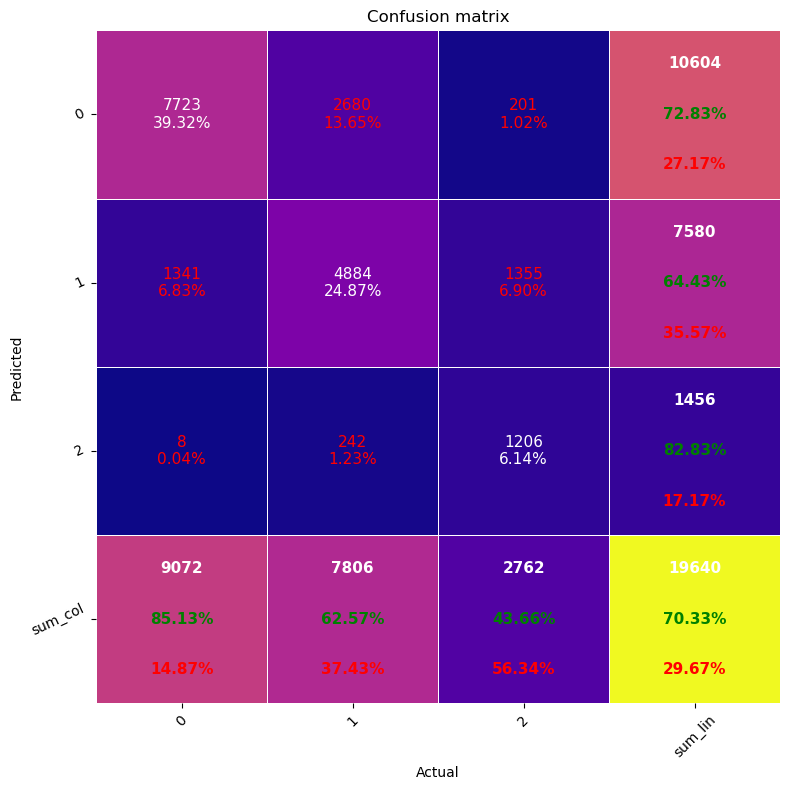

FileNotFoundError: [Errno 2] No such file or directory: 'housing_notebook/housing_conf_matrix.png'

<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np
import pandas as pd
from pretty_confusion_matrix import pp_matrix
from matplotlib import colormaps
conf_m=tf.math.confusion_matrix(y_test,[np.argmax(x) for x in model.predict(Z_test)])
# get pandas dataframe
df_cm = pd.DataFrame(conf_m, index=range(n_classes-1), columns=range(n_classes-1))
#for i in range(len(list(colormaps))):
#    print(i)
cmap = list(colormaps)[2]
pp_matrix(df_cm, cmap=cmap)
plt.savefig(plots_dir + "housing_conf_matrix.png")

## $D(f)$ for each class

Label:  0


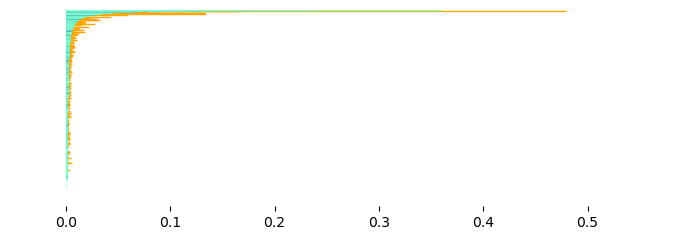

<Figure size 640x480 with 0 Axes>

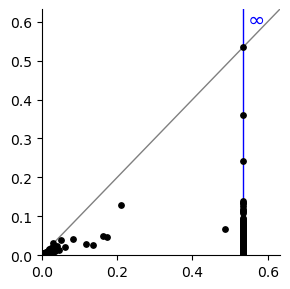

Label:  1


<Figure size 640x480 with 0 Axes>

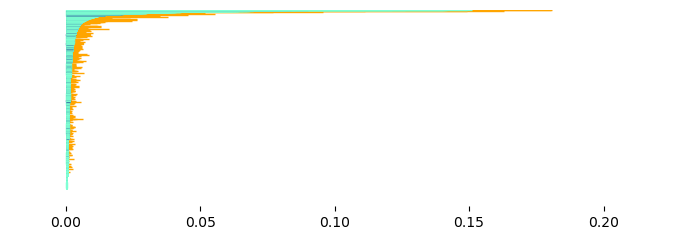

<Figure size 640x480 with 0 Axes>

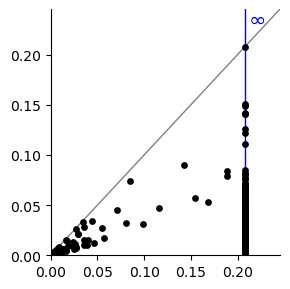

Label:  2


In [ ]:
for i in set(labels):
    print("Label: ",i)
    Xi = X[y==i]
    yi = y[y==i]
    Zi = Z[labels==i]
    Zi_indices = np.argwhere(labels==i).flatten() # Respect to X
    Xi_indices = X_indices[y==i] # Respect to X
    Xi_indices=[np.argwhere(Zi_indices==x).flatten()[0] for x in Xi_indices]
    
    
    Xi_compl = np.ones(Zi.shape[0], dtype="bool")
    Xi_compl[Xi_indices] = False
    Zi = np.vstack((Zi[Xi_indices], Zi[Xi_compl]))
    Xi_indices = range(len(Xi_indices))
    Xi = Zi[Xi_indices]
    filt_Xi, filt_Zi, matchingi = tdqual.compute_Mf_0(Xi,Zi)

    fig, ax = plt.subplots(figsize=(7,2.5))
    tdqual.plot_matching_0(filt_Xi, filt_Zi, matchingi, ax)
    plt.tight_layout()
    plt.show()
    plt.savefig(plots_dir + "block_matching_0_c"+str(i)+".png")

    fig, ax = plt.subplots(figsize=(3,3))
    D_fi, multiplicitiesi = tdqual.compute_matching_diagram(filt_Xi, filt_Zi, matchingi, _tol=1e-5)
    tdqual.plot_matching_diagram(D_fi, ax)
    plt.tight_layout()
    plt.show()
    plt.savefig(plots_dir + "matching_diagram_0_c"+str(i)+".png")
    
    

## $D(f)$ 

In [ ]:
X_compl = np.ones(Z.shape[0], dtype="bool")
X_compl[X_indices] = False
Z = np.vstack((Z[X_indices], Z[X_compl]))
X_indices_old = X_indices
X_indices = range(len(X_indices))
X = Z[X_indices]
filt_X, filt_Z, matching = tdqual.compute_Mf_0(X,Z)

fig, ax = plt.subplots(figsize=(7,2.5))
tdqual.plot_matching_0(filt_X, filt_Z, matching, ax)
plt.tight_layout()
plt.show()
plt.savefig(plots_dir + "block_matching_0.png")

fig, ax = plt.subplots(figsize=(3,3))
D_f, multiplicities = tdqual.compute_matching_diagram(filt_X, filt_Z, matching, _tol=1e-5)
tdqual.plot_matching_diagram(D_f, ax)
plt.tight_layout()
plt.show()
plt.savefig(plots_dir + "matching_diagram_0.png")